# Unsupervised Anomaly Detection

We continue with anomaly detection by focusing now on unsupervised anomaly detection. Recall, you can think of an anomaly as some sort of highly unusual event occuring in your data that you wish to find (e.g. an attack on your network, a defective device, credit card fraud). More usefully, a good definition of an anomaly is the following: An anomaly is a data sample that deviates significantly from other data samples, so much so to suggest that it was generated by a different mechanism. In probability language, you can think of an anomaly as something that comes from a different distribution than the "real" data.

Unsupervised anomaly detection deals with the case where we don't know ahead of time which points in our dataset are anomalies. The goal is to find structure in the data and to use that structure to find points that are "out of place". What does it mean for a point to be out of place? Usually this means the point is unusually "far away" from most of the data in some sense. In statistical lingo this is often called [outlier detection](http://scikit-learn.org/stable/modules/outlier_detection.html).

Note, however, that not all anomalies are outliers! One example of a non-outlier anomaly is the "faulty sensor" anomaly. These often result in having lots of points in your dataset taking the same or similar values. If that value happens to be inside your "good data" values you'll probably never catch it with these techniques. Another example of a non-outlier anomaly is the "cluster" anomaly. These result in having sets of points forming one or more clusters, which may be hard to pick out from the "good" data. An example of this could be a sudden burst in activity over a network. Unsupervised techniques will often not work very well for these types of anomalies, as they're largely based on finding outliers.

As always, we begin by loading the packages we'll use and defining a few useful functions for getting the data and plotting stuff. We'll primarily be sticking with sklearn here for our detection techniques.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
np.random.seed(4)

import warnings
warnings.filterwarnings('ignore')

In [43]:
def get_data(size=1000,ratio=0.01):
    num_neg_samples = round(size*(1-ratio))
    num_pos_samples = round(size*ratio)
    X_neg = np.random.multivariate_normal(np.array([0,0]),.5*np.eye(2),size=num_neg_samples)
    #X_neg = np.vstack([np.random.multivariate_normal(np.array([2.5,0]),.5*np.eye(2),size=num_neg_samples//2),
    #                  np.random.multivariate_normal(np.array([-2.5,0]),np.random.rand(2,2),size=num_neg_samples//2)])
    y_neg = np.zeros(len(X_neg))
    X_pos = get_pos_samples(num_pos_samples)
    y_pos = np.ones(len(X_pos))
    X = np.vstack([X_neg,X_pos])
    y = np.concatenate([y_neg,y_pos])
    idx = np.random.permutation(len(y))
    X = X[idx]
    y = y[idx]
    return X,y

def get_pos_samples(n,lim=3):
    # generates anomalies from a mixture distribution
    # consists of 1 U(-lim,lim) + 3 N(mean,cov) with random means and covs
    x = np.zeros((n,2))
    idx = np.arange(n)
    
    mean = np.random.uniform(-lim,lim,size=2)
    cov = .05*np.random.rand()*np.eye(2)
    for i in idx[:n//2]:
        x[i] = np.random.multivariate_normal(mean,cov,size=1)

    mean = np.random.uniform(-lim,lim,size=2)
    cov = .01*np.random.rand()*np.eye(2)
    for i in idx[n//2:]:
        x[i] = np.random.multivariate_normal(mean,cov,size=1)

    #mean = np.random.uniform(-lim,lim,size=2)
    #cov = .01*np.random.rand()*np.eye(2)
    #for i in idx[2*n//3:]:
    #    x[i] = np.random.multivariate_normal(mean,cov,size=1)

    u = np.zeros((5,2))
    for i in range(5):
        u[i] = np.random.uniform(-lim+1,lim+1,size=2)

    z = np.zeros((2,2))    
        
    return np.vstack([x,u,z])

def plot_data(X,y,yhat=None):
    lim = np.max(np.abs(X))
    f, ax = plt.subplots(figsize=(8, 8))    
    ax.scatter(X[y==0][:,0],X[y==0][:,1],marker='.',c='blue',s=10,alpha=0.5,label='normal data')
    ax.scatter(X[y==1][:,0],X[y==1][:,1],marker='.',c='red',s=50,label='anomalies')
    if yhat is not None:
        ax.scatter(X[yhat==1][:,0],X[yhat==1][:,1],marker='.',c='green',s=50,label='predicted anomalies')
    ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
    ax.legend(loc='upper right')
    plt.xlim(-lim-.5,lim+.5)
    plt.ylim(-lim-.5,lim+.5)
    plt.show()
    
def get_scores(y,yhat):   
    print('precision: ', round(precision_score(y,yhat),4))
    print('recall: ', round(recall_score(y,yhat),4))
    print('f1: ', round(f1_score(y,yhat),4))
    print('number of anomalies found:',(yhat[y==1] == y[y==1]).sum(),'out of',len(y[y==1]))
    print('confusion matrix:\n', confusion_matrix(y,yhat))
    
def adjust_labels(yhat):
    yhat[yhat==1] = 0
    yhat[yhat==-1] = 1
    return yhat

Now we load in the data. The non-anomalous points were generated from a 2D Gaussian distribution, while the anomalous points were generated from a complicated mixture distribution. Since I generated the anomalies myself, we can keep track of the "labels" in `y` just for plotting and evaluation purposes. The models we'll use below will only use the feature data `X` though since we're doing unsupervised learning. Note that in real life you usually won't know which points in your dataset are anomalies. You're almost always "flying blind" when doing unsupervised anomaly detection.

In this case, about 1% of the data are anomalous, which comes out to about 22 in 1485 points. A plot of the data is shown below as well, with the anomalies we're trying to "discover" highlighted in red. You can see we have a mix of different types of anomalies to detect. Some are random outliers, some are clusters, and some are "faulty sensor" types centered at the origin.

Number of non-anomalies: 1485
Number of anomalies: 22
Percent anomalies in dataset: 1.46 %


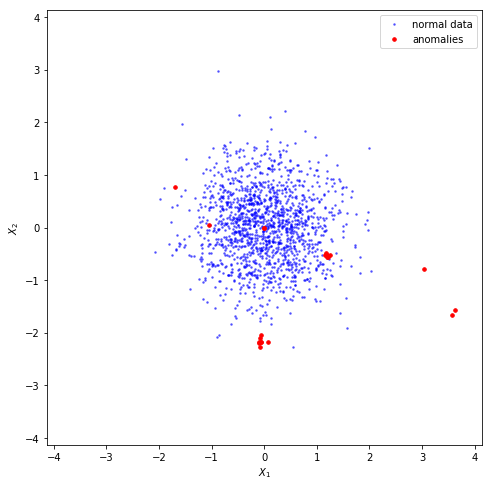

In [44]:
X,y = get_data(1500,0.01)
print('Number of non-anomalies:',len(y[y==0]))
print('Number of anomalies:',len(y[y==1]))
print('Percent anomalies in dataset:',round(len(y[y==1])/(len(y[y==0])+len(y[y==1]))*100,2),'%')
plot_data(X,y)

The first thing you'd likely try when finding outlier-type anomalies is just looking for points that are "far away" from most of your data. In probability language, you're looking for "low probability events". If we assume the good data is Gaussian distributed (which in our case it is, by sheer luck), you can try fitting a Gaussian to the data and classifying points "too far away" (i.e. points that occur in the tails of the distribution) as anomalies. Note this technique will not work well if your "normal" data is multimodal (i.e. has multiple clusters)!

In sklearn this is done with the `EllipticEnvelope` class. One caveat to use this technique is we have to tell the API how many points about we think are outliers. Assuming we know roughly what the fraction of outliers is, in our case about 1.5%, we can specify that (0.015), otherwise one has to guess. Generally the number should be small, no more than a few percent.

From the confusion matrix, we can see that the model correctly identified 10 of our 22 anomalies. Is this good?

precision:  0.4348
recall:  0.4545
f1:  0.4444
number of anomalies found: 10 out of 22
confusion matrix:
 [[1472   13]
 [  12   10]]


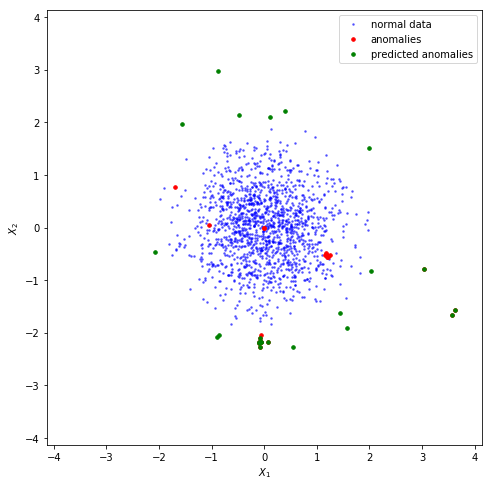

In [45]:
model = EllipticEnvelope(contamination=0.015)
model.fit(X)
yhat = model.predict(X)

yhat = adjust_labels(yhat)
get_scores(y,yhat)
plot_data(X,y,yhat)

A popular non-parametric technique that doesn't require you to assume anything about your data is isolation forests. These are basically just a small variation on random forests. Instead of predicting a label, it uses the average tree depth to predict whether a point is an anomaly.

In sklearn this is done using the `IsolationForest` class. Just like with `EllipticEnvelope`, we have to specify the approximate ratio of outliers in the dataset using the `contamination` parameter. We again set it to 1.5% since that's roughly how many we have. It looks like Isolation Forests is performing worse than Elliptic Envelopes in this case, only finding 8 of 22 anomalies, at least with minimal tuning to the forest.

precision:  0.3478
recall:  0.3636
f1:  0.3556
number of anomalies found: 8 out of 22
confusion matrix:
 [[1470   15]
 [  14    8]]


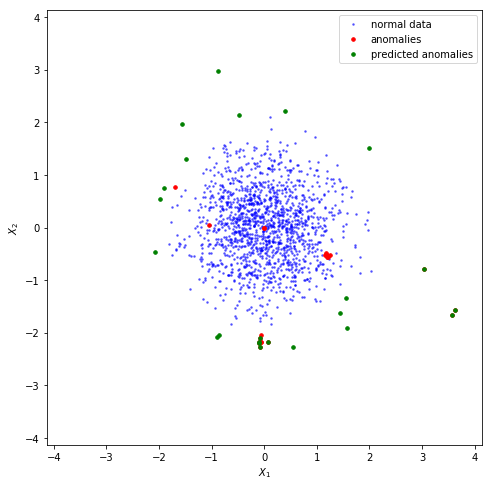

In [46]:
model = IsolationForest(contamination=0.015)
model.fit(X)
yhat = model.predict(X)

yhat = adjust_labels(yhat)
get_scores(y,yhat)
plot_data(X,y,yhat)

Another classic anomaly detection technique is the [one-class](https://en.wikipedia.org/wiki/One-class_classification) support vector machine (SVM). [SVMs](https://en.wikipedia.org/wiki/Support_vector_machine) are fairly old classification models that tend to perform somewhere in between logistic regression and random forests / neural nets. They were very popular like 15 years ago but have since fallen largely out of favor. At any rate, one-class SVMs can perform fairly well for anomaly detection if tuned properly.

In sklearn these are done using the `OneClassSVM`. The `nu` parameter functions something like contamination above. You can see we're doing a bit better here, identifying 12 of 22 anomalies. Note how many false positives we're picking up though (140). This may or may not concern you depending on your situation.

precision:  0.0789
recall:  0.5455
f1:  0.1379
number of anomalies found: 12 out of 22
confusion matrix:
 [[1345  140]
 [  10   12]]


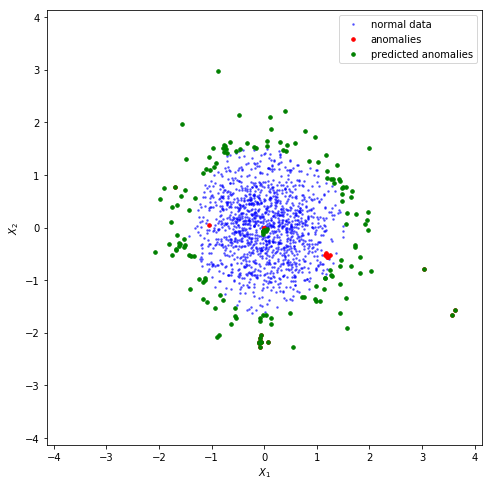

In [47]:
model = OneClassSVM(nu=0.1)
model.fit(X)
yhat = model.predict(X)

yhat = adjust_labels(yhat)
get_scores(y,yhat)
plot_data(X,y,yhat)

The last unsupervised technique we mention here is local outlier factor (LOF). LOF tries to detect outliers by density using a variation on KNN. This can allow LOF to work in situations where you're not looking for "outliers" per se, but for regions of abnormal density (think cluster type anomalies).

In sklearn this is done with the `LocalOutlierFactor` class. We must specify a contamination rate for these. It also may help to adjust the number of `n_neighbors` to catch various densities. You can see that in this case we only catch 10 of 22 anomalies.

precision:  0.4348
recall:  0.4545
f1:  0.4444
number of anomalies found: 10 out of 22
confusion matrix:
 [[1472   13]
 [  12   10]]


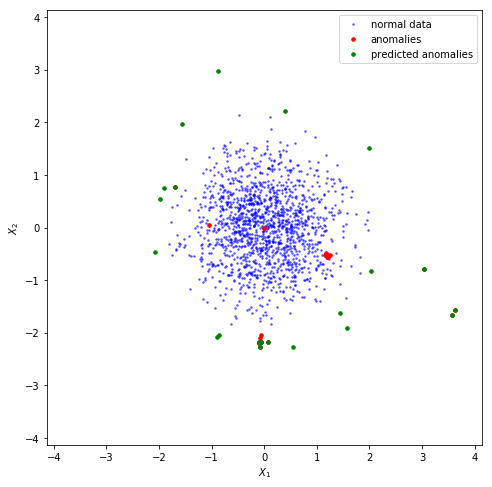

In [48]:
model = LocalOutlierFactor(n_neighbors=80,contamination=0.015,n_jobs=-1)
yhat = model.fit_predict(X)

yhat = adjust_labels(yhat)
get_scores(y,yhat)
plot_data(X,y,yhat)

I want to close by making a point. Suppose we actually did know what the labels were for some of our data. How much better could we do just by knowing that information? Equivalently, how much better could we do if we were able to use supervised learning instead? We quickly answer this question below.

We assume now like last week that we have a labeled dataset with "-1"s being anomalies and "1"s being non-anomalies (sorry it's different than last week, one of those weird sklearn things). We first split the dataset up into a training and test set, and then apply SMOTE to the training set. We then fit a random forest classifier to the data, evaluate the model, and plot the results. Notice we found all 22 anomalies, or all 6 of the anomalies that were held out for the test set.

Moral: You can't beat having labels. You will almost always do better using supervised learning techniques if you can find a way to get some labeled data to train with.

precision:  0.2973
recall:  1.0
f1:  0.4583
number of anomalies found: 22 out of 22
confusion matrix:
 [[1433   52]
 [   0   22]]


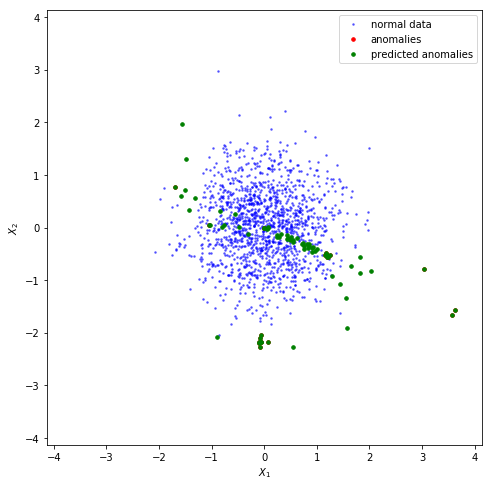

In [49]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
X_train_bal,y_train_bal = SMOTE().fit_sample(X_train,y_train)

model = RandomForestClassifier(min_samples_leaf=5, n_jobs=-1)
model.fit(X_train_bal,y_train_bal)
yhat = model.predict(X)

get_scores(y,yhat)
plot_data(X,y,yhat)